# Librerias

In [2]:
# from oficial python
import numpy as np
import matplotlib.pyplot as plt
from qutip import Bloch
from matplotlib import cm
import matplotlib as mpl
from qutip import basis, tensor
import time
from sklearn.model_selection import train_test_split
import pennylane as qml
import os
import pandas as pd

# own modules:
from dll.spin_procesor_modificated import Quantum_Spin_Proces
from dll.main_fun import make_IRIS_v2, pulse_x_with_noise, pulse_x, pulse_z
from dll. baseline_dru_v2 import Modelo_DRU
from dll.models import qcircuit_1_qubit_mixed, qcircuit_2_qubit_mixed, qcircuit_4_qubit_mixed
from dll.cost_functions import fidelity_cost
from dll.gate_procesor_modificated import CompositeGateProcessor

In [3]:
def calculate_fidelity(state_base_line, state_spins):
  # convert spin to dm
  nf, nc = state_spins.shape
  if nc == 1:
    dm_spin = state_spins @ state_spins.conj().T
  # calculare fidelity:
  F  = qml.math.fidelity(state_base_line, dm_spin)
  return F
  

# Proceso general

In [12]:
# Global
N_qubits = 1

# Base line parameters
N_layeres = 3
n_classes = 3
n_features = 3
Epocas = 2
# Spin processor parameters:

configuration_cases = {
            # MODEL entanglement, floss, Nlayers, Nqubits
  "case_1": [1, False],
  "case_2": [2, False],
  "case_3": [2, True],
  "case_4": [4, False],
  "case_5": [4, True]
}

Results_fidel = []

for key_case in configuration_cases:
  
  N_qubits, entan = configuration_cases[key_case]
  
  
  if entan == False:
    N_true_layer = N_layeres
  else:
    if N_qubits == 2:
      N_true_layer = 2*N_layeres
    else:
      N_true_layer = 2*N_layeres - 1
  
  #entan = False

  ket0 =  tensor([basis(2, 0)]*N_qubits)

  nombre_funcion = f"qcircuit_{N_qubits}_qubit_mixed"
  model_circuit = globals().get(nombre_funcion)

  model = Modelo_DRU(model_circuit, fidelity_cost,
                    epochs = Epocas, n_clases = n_classes, n_qubits = N_qubits,
                    features = n_features, alpha_noise = 0.0, save_process=False,
                    num_layers = N_layeres, entanglement = entan)

  X, y =  make_IRIS_v2(n_features, n_classes)

  # splita data:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

  # get optimized parameters
  paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

  # TRAIN =================================

  # Train proces
  Fidel_intra_states_train = np.zeros((len(model.X_train), N_true_layer))


  for i, x_train_point in enumerate(model.X_train):
    
    # Intra states del base line:
    states_base_line = qml.snapshots(model_circuit)(paramters_1q, x_train_point, bias=bias_1q,  entanglement=entan)
    
    # Generar intra states de spin processor:
    dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=5, n_points_pulse_Ri_spl = 100, version_qutip="5",
                                      N_qubits = N_qubits, tf_noise = False, tf_quantum_noise = False,
                                      ket_dru_0 = ket0, save_intra_states=True)                        
    #state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_1q, x_train_point, bias=bias_1q)
    metodo = getattr(dru_circuit, f"qcircuit_DRU_{N_qubits}_Qubit", None)
    state_dru = metodo(paramters_1q, x_train_point, bias=bias_1q,  entanglement=entan)
    # Por cada intra state calcular fidelidad:
    for j, key in enumerate(dru_circuit.dict_states):
      # get intra-state de base line:
      state_base_line = states_base_line[key]
      # get intra-state de QIUP:
      state_spin = dru_circuit.dict_states[key]
      # calcule fidelity:
      F = calculate_fidelity(state_base_line, state_spin)
      # save fidelity:
      Fidel_intra_states_train[i,j] = F

  # Calcula el promedio de cada columna
  mean_train = np.mean(Fidel_intra_states_train, axis=0)
  # Calcula la desviación estándar de cada columna
  std_dev_train = np.std(Fidel_intra_states_train, axis=0)

  # Test =================================

  # Train proces
  Fidel_intra_states_test = np.zeros((len(model.X_val), N_true_layer))

  for i, x_test_point in enumerate(model.X_val):
    
    # Intra states del base line:
    states_base_line = qml.snapshots(model_circuit)(paramters_1q, x_test_point, bias=bias_1q,  entanglement=entan)
    
    # Generar intra states de spin processor:
    dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=5, n_points_pulse_Ri_spl = 100, version_qutip="5",
                                      N_qubits = N_qubits, tf_noise = False, tf_quantum_noise = False,
                                      ket_dru_0 = ket0, save_intra_states=True)                        
    metodo = getattr(dru_circuit, f"qcircuit_DRU_{N_qubits}_Qubit", None)
    state_dru = metodo(paramters_1q, x_test_point, bias=bias_1q,  entanglement=entan)
    
    # Por cada intra state calcular fidelidad:
    for j, key in enumerate(dru_circuit.dict_states):
      # get intra-state de base line:
      state_base_line = states_base_line[key]
      # get intra-state de QIUP:
      state_spin = dru_circuit.dict_states[key]
      # calcule fidelity:
      F = calculate_fidelity(state_base_line, state_spin)
      # save fidelity:
      Fidel_intra_states_test[i,j] = F

  # Calcula el promedio de cada columna
  mean_test = np.mean(Fidel_intra_states_test, axis=0)
  # Calcula la desviación estándar de cada columna
  std_dev_test = np.std(Fidel_intra_states_test, axis=0)
  
  # save results:
  df = pd.DataFrame({
    "States": list(dru_circuit.dict_states.keys()),
    "Mean Fidel train": mean_train.tolist(),
    "Mean Fidel test": mean_test.tolist(),
    "Std Fidel train": std_dev_train.tolist(),
    "Std Fidel test": std_dev_test.tolist()
  })
  path_save_excel = os.path.join("results_of_test","test_3")
  df.to_excel(os.path.join(path_save_excel, f"Fidelity_result_intra_states_q_{N_qubits}_engl_{entan}.xlsx"), index=False)


Epoch: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
Epoch: 100%|██████████| 2/2 [00:04<00:00,  2.30s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
Epoch: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
Epoch: 100%|██████████| 2/2 [00:08<00:00,  4.34s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedi

# Pulsos

In [23]:
def plot_pulses_v2(self, verbose = 1, key_show = 'all'):
  resultado = self.pulse_type
  glob_time = self.global_time
  for key in resultado:
    list_pulses = resultado[key]
    if list_pulses[0]['Type_pulse'] == 'Unitary':
      global_time_sim = np.linspace(0, dru_circuit.global_time , 1000)
      B1_pulses = np.zeros(len(global_time_sim ))
      B0_pulses = np.zeros(len(global_time_sim ))
      for dict_pulse in list_pulses:
        # B0 results
        args2= {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f']}
        B0_i = dict_pulse['B0'] * pulse_z(
                                  global_time_sim,
                                  args2)
        B0_pulses += np.array(B0_i)
        # B1 results
        # Correccion:
        if dict_pulse['B1'] != 0:
          dv = self.noise_std/abs(dict_pulse['B1'])
        else:
          dv = 0
        args2= {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f'], "std_noise": dv }
        B1_i = dict_pulse['B1'] * pulse_x_with_noise(
                                  global_time_sim,
                                  args2)
        B1_pulses += np.array(B1_i)
      # Plot
      plt.figure(figsize=(8,3))
      plt.plot(global_time_sim* 1e6, B0_pulses,linewidth=1.7, color='darkblue')
      plt.title("Pulse sequence for B0")
      plt.xlabel("time [µs]")
      plt.ylabel("B0 [T]")
      plt.grid()
      plt.show()

      plt.figure(figsize=(8,3))
      plt.plot(global_time_sim* 1e6, B1_pulses,linewidth=1.7, color='darkblue')
      plt.title("Pulse sequence for B1")
      plt.xlabel("time [µs]")
      plt.ylabel("B1 [T]")
      plt.grid()
      plt.show()

    elif list_pulses[0]['Type_pulse'] == "Two_Qubits":
      print("Entre")
      global_time_sim = np.linspace(0, dru_circuit.global_time , 100000)
      J_pulses = np.zeros(len(global_time_sim ))
      for dict_pulse in list_pulses:
        args2= {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f']}
        J_i = dict_pulse['J'] * pulse_x(
                                  global_time_sim,
                                  args2)
        J_pulses += np.array(J_i)
      fig, ax = plt.subplots(figsize=(8,3))
      ax.plot(global_time_sim, J_pulses, linewidth=1.7, color='darkblue')
      ax.set_xlabel("time [ns]")
      ax.set_label("J")
      
      x1, x2, y1, y2 = 13.5/1e9, 13.9/1e9, 0, 1.2e12
      # Añadir la inserción (inset) en la gráfica principal
      axins = ax.inset_axes([0.6, 0.6, 0.35, 0.35])
      axins.plot(global_time_sim, J_pulses, drawstyle='steps-post', color='blue')

      # Definir el área de zoom
      axins.set_xlim(x1, x2)
      axins.set_ylim(y1, y2)
      axins.set_xticks(np.arange(x1, x2, 2))
      axins.set_yticks(np.linspace(y1, y2, 3))

      # Añadir una caja de zoom y las líneas de conexión
      ax.indicate_inset_zoom(axins, edgecolor="black")
      

In [13]:
X, y =  make_IRIS_v2(3,3)

model = Modelo_DRU(qcircuit_1_qubit_mixed, fidelity_cost,
                        epochs = 5, n_clases = 3, n_qubits = 1,
                        features = 3, num_layers = 10, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = False)

# splita data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# get optimized parameters
paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=100,
                                     N_qubits = 1,
                                     tf_noise = False,
                                     noise_std = 0.0000, save_pulses= True)

state_dru = dru_circuit.qcircuit_DRU_1_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q)

Epoch: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


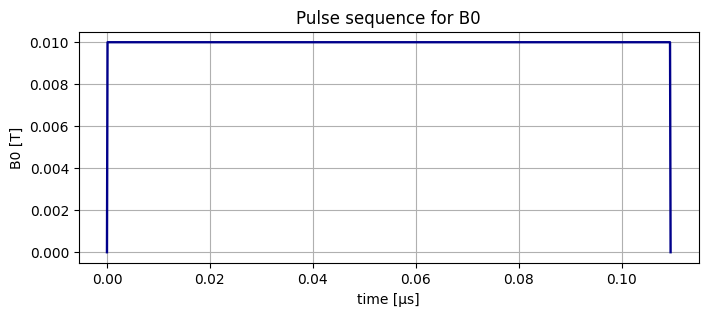

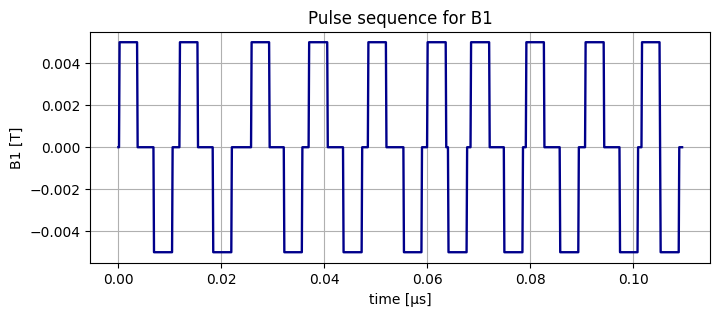

In [ ]:
plot_pulses_v2(dru_circuit)

In [17]:
X, y =  make_IRIS_v2(3,3)

tf_entanglement = True

model = Modelo_DRU(qcircuit_2_qubit_mixed, fidelity_cost,
                        epochs = 2, n_clases = 3, n_qubits = 2,
                        features = 3, num_layers = 4, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = True,
                        entanglement = tf_entanglement )

# splita data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# get optimized parameters
paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000,
                                     N_qubits = 2,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0)),
                                     save_pulses= True)

state_dru = dru_circuit.qcircuit_DRU_2_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q,
                                             entanglement = tf_entanglement)

Epoch: 100%|██████████| 2/2 [00:06<00:00,  3.13s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


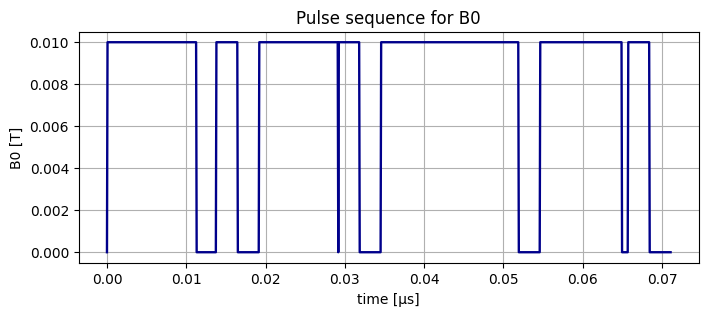

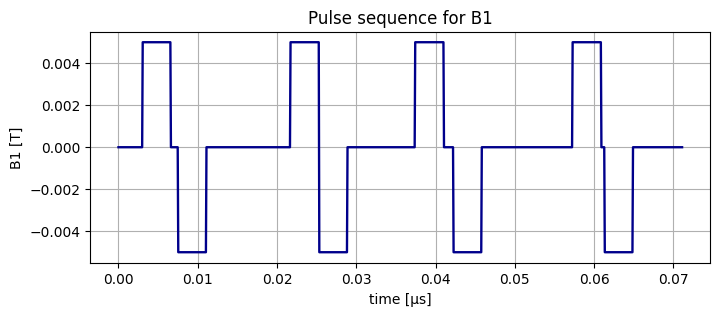

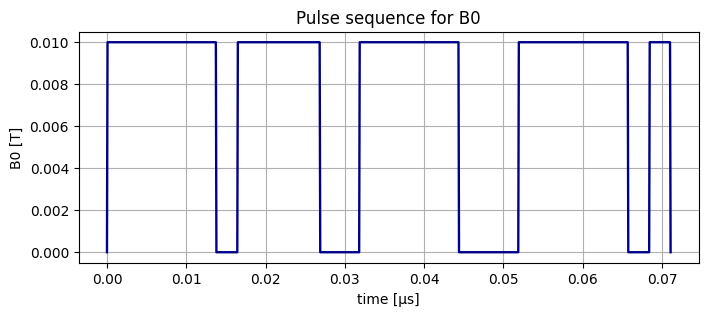

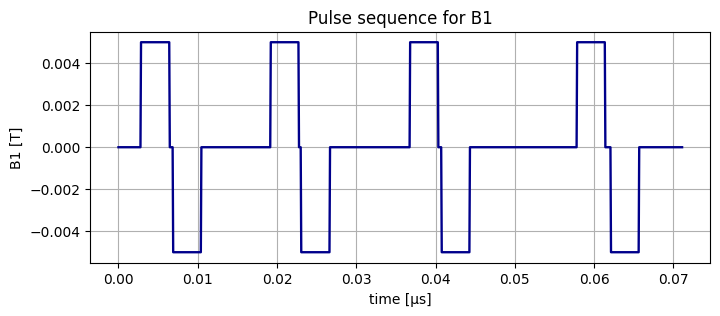

Entre


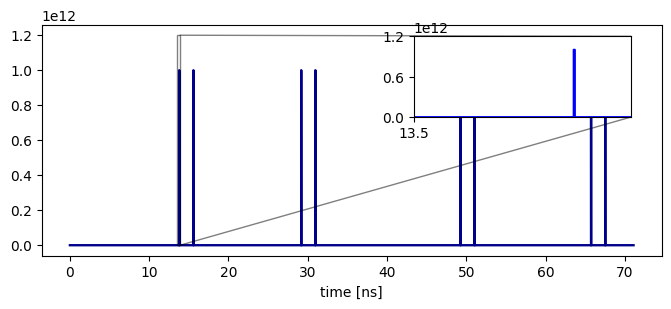

In [22]:
plot_pulses_v2(dru_circuit)

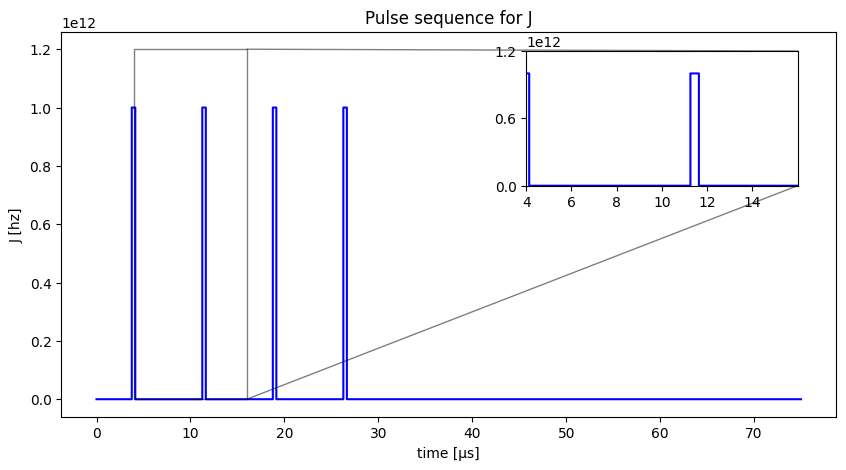

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
t = np.linspace(0, 75, 1000)
J = np.zeros_like(t)
J[50:55] = 1e12
J[150:155] = 1e12
J[250:255] = 1e12
J[350:355] = 1e12

# Crear la figura principal
fig, ax = plt.subplots(figsize=(10, 5))

# Graficar la secuencia de pulsos en la gráfica principal
ax.plot(t, J, drawstyle='steps-post', color='blue')

# Establecer etiquetas y título
ax.set_xlabel('time [µs]')
ax.set_ylabel('J [hz]')
ax.set_title('Pulse sequence for J')

# Crear la gráfica de inserción
# Definir los límites para el zoom, por ejemplo en el primer pulso
x1, x2, y1, y2 = 4, 16, 0, 1.2e12

# Añadir la inserción (inset) en la gráfica principal
axins = ax.inset_axes([0.6, 0.6, 0.35, 0.35])
axins.plot(t, J, drawstyle='steps-post', color='blue')

# Definir el área de zoom
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks(np.arange(x1, x2, 2))
axins.set_yticks(np.linspace(y1, y2, 3))

# Añadir una caja de zoom y las líneas de conexión
ax.indicate_inset_zoom(axins, edgecolor="black")

# Mostrar la gráfica
plt.show()

